# Core Demo Dashboard

Objective: Create a Data Science Notebook, using ECommerce Dataset, to include forecasting visualisations of the created model for the demo dashboard shown to prospective clients.

Created By: Stephen Cole

Creation Date: 2023-04-06

### Last Updated

In [1]:
%load_ext pretty_jupyter

from datetime import datetime, timedelta

print(f"Last Updated: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

Last Updated: 18/04/2023 13:10:00


## Introduction

Brazilian E-Commerce Public Dataset by Olist Welcome. This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. It's features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. They also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates. 

> A separate dataset was created to supplement the State codes and provide full description of the state, rather than just the code.

## 1.0 Preliminary Setup
[//]: # (-.- .tabset .tabset-pills)

### 1.1 Import Packages

In [34]:
import os
import time
import logging
import pickle
import yaml
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from googletrans import Translator, constants

from functions.DS_PreProcessing_Functions import reduce_mem_usage, separate_column_dtypes, convert_data_types
from functions.DS_PreProcessing_Functions import convert_date_columns, print_null_percentages

pd.set_option('display.max_columns', None, 'display.max_rows', 500)

### 1.2 Load Config File

In [3]:
path_to_config = "C:/Users/Stephen.Cole/Dropbox/My PC (XT-LPT-012)/Documents/Core Consultants/Internal Dashboard/Python\
/python_config/python_config.yaml"

# Load config
with open (path_to_config,'r') as stream:
    demo_dashboard_config = yaml.safe_load(stream)

### 1.3 Setup Log File

In [4]:
path_to_log = demo_dashboard_config['Paths']['path_to_log']

# Setting up log file
os.makedirs(path_to_log, exist_ok=True)

run_date = datetime.today().strftime('%Y-%m-%d')
log_file_name = run_date + "_demo_dashboard.log"
path_to_log_file = os.path.join(path_to_log, log_file_name)

logging.basicConfig(filename=path_to_log_file,
                   filemode='w',
                   format='%(asctime)s %(name)s %(levelname)s %(message)s',
                   level=logging.INFO,
                   datefmt='%Y-%m-%d')

LOGGER = logging.getLogger(__name__)

### 1.4 Load Data

In [5]:
def create_dfs(dataframe_names, file_paths, LOGGER = LOGGER):
    start_time = time.time()
    dfs = {}
    for name, file in zip(dataframe_names, file_paths):
        try:
            dfs[name] = pd.read_csv(file)
            LOGGER.info(f"Data file {file} read SUCCESSFULLY")
            LOGGER.info(f"Data file {file} has {dfs[name].shape} [rows, columns]")
        except Exception as e:
            LOGGER.info(f"Data file {file} read UNSUCCESSFULLY with exception {e}")
    time_elapsed = time.time() - start_time
    LOGGER.info("Data files read, time elapsed: {}".format(str(timedelta(seconds=time_elapsed))))
    return dfs

In [6]:
var_names = ["Customers", "Geolocation", "Items", "Payments", "Reviews", "Orders", 
             "Products", "Sellers", "Products_translation"]
input_file_paths = [os.path.join(demo_dashboard_config['Paths']['path_to_data'], file) for file in demo_dashboard_config['Files']['input_csv']]

dfs = create_dfs(var_names, input_file_paths)

## 2.0 Data Model 

There are 100k orders from 2016 to 2018, with 9 datasets to investigate. The Data Model can be described in the image below:

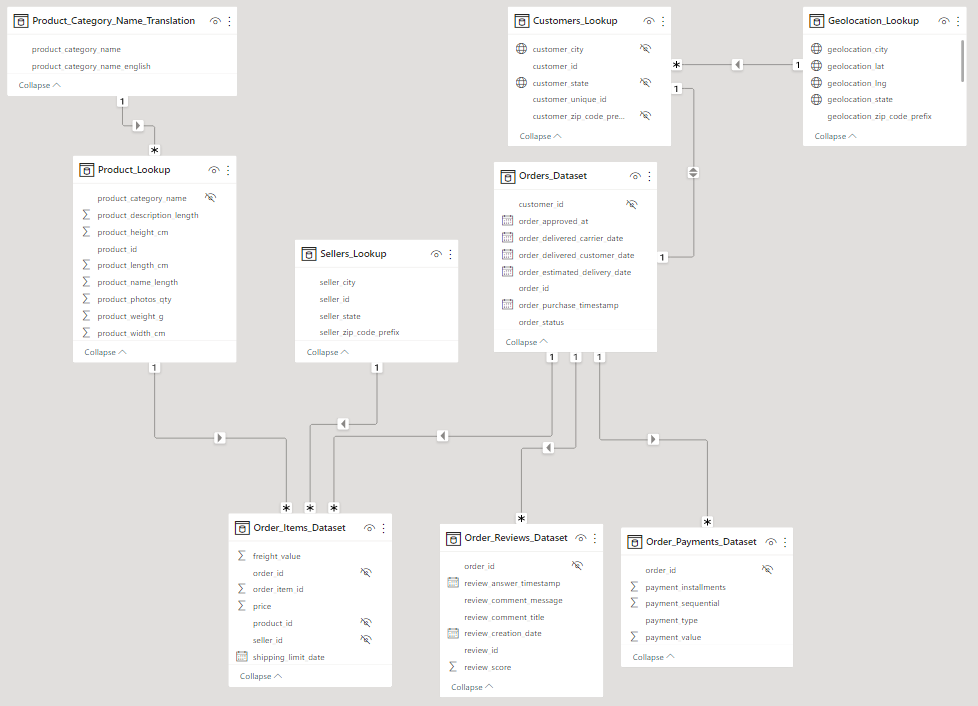


### 2.1 Principal Dataset

Order Reviews Dataset

 - Review ID (```object```)
 - Order ID (```object```)
 - Review Score (```int64```)
 - Review Comment Title (```object```)
 - Review Comment Message (```object```)
 - Review Creation Date (```object```)
 - Review Answer Timestamp (```object```)
 
 > NOTE: ```review_comment_title``` and ```review_comment_message``` will be converted to English and passed through an NLP model to create a new features that will hopefully help contribute to predicting the ```review_score```

In [7]:
display(dfs["Reviews"].loc[~dfs["Reviews"]["review_comment_title"].isna(),:].set_index("review_id").head())

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25
c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,2018-06-07 00:00:00,2018-06-09 18:44:02


### 2.2 Other Datasets
[//]: # (-.- .tabset .tabset-pills)

#### 2.2.1 Customers Dataset

- Customer ID (```object```)
- Customer Unique ID (```object```)
- Customer ZIP Code Prefix (```int64```)
- Customer City (```object```)
- Customer State (```object```)

In [8]:
display(dfs["Customers"].set_index("customer_id").head())

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
customer_id,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


#### 2.2.2 Geolocation Lookup

- Geolocation ZIP Code Prefix (```int64```)
- Geolocation Latitude (```float64```)
- Geolocation Longitude (```float64```)
- Geolocation City (```object```)
- Geolocation State (```object```)

> NOTE: This Lookup table will not be used for modelling so can be ignore throughout.

In [9]:
display(dfs["Geolocation"].set_index("geolocation_zip_code_prefix").head())

,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
geolocation_zip_code_prefix,,,,
1037,-23.545621,-46.639292,sao paulo,SP
1046,-23.546081,-46.644820,sao paulo,SP
1046,-23.546129,-46.642951,sao paulo,SP
1041,-23.544392,-46.639499,sao paulo,SP
1035,-23.541578,-46.641607,sao paulo,SP


#### 2.2.3 Orders Dataset

- Order ID (object)
- Customer ID (object)
- Order Status (object)
- Order Purchase Timestamp (object)
- Order Approved at (object)
- Order Delivered Carrier date (object)
- Order Estimated Delivery date (object)

In [10]:
display(dfs["Orders"].set_index("order_id").head())

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_id,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### 2.2.4 Sellers Lookup

- Seller ID (```object```)
- Seller ZIP Code Prefix (```int64```)
- Seller City (```object```)
- Seller State (```object```)

In [11]:
display(dfs["Sellers"].set_index("seller_id").head())

,seller_zip_code_prefix,seller_city,seller_state
seller_id,,,
3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


#### 2.2.5 Product Category Name Translation

- Product Category Name (```object```)
- Product Category Name English (```object```)

In [12]:
display(dfs["Products_translation"].set_index("product_category_name").head())

,product_category_name_english
product_category_name,
beleza_saude,health_beauty
informatica_acessorios,computers_accessories
automotivo,auto
cama_mesa_banho,bed_bath_table
moveis_decoracao,furniture_decor


#### 2.2.6 Product Lookup

- Product ID (```object```)
- Product Category Name (```object```)
- Product Name Length (```float64```)
- Product Description Length (```float64```)
- Product Photos qty (```float64```)
- Product Weight g (```float64```)
- Product Length cm (```float64```)
- Product Height cm (```float64```)
- Product Width cm (```float64```)

In [13]:
display(dfs["Products"].set_index("product_id").head())

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


#### 2.2.7 Order Items Dataset

- Order ID (```object```)
- Order Item ID (```int64```)
- Product ID (```object```)
- Seller ID (```object```)
- Shipping Limit Date (```object```)
- Price (```float64```)
- Freight Value (```float64```)

In [14]:
display(dfs["Items"].set_index("order_id").head())

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
order_id,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


#### 2.2.8 Order Payments Dataset

- Order ID (```object```)
- Payment Sequential (```int64```)
- Payment Type (```object```)
- Payment Installments (```int64```)
- Payment Value (```float64```)

In [15]:
display(dfs["Payments"].set_index("order_id").head())

,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


## 3.0 Feature Engineering
[//]: # (-.- .tabset .tabset-pills)

Perform relevant data cleaning, standardisation and feature engineering

### 3.1 Creating the "Single Source of Truth" Table

Will join all the relevant tables together to create a single table that contains all the useful features. This will make data cleaning, standardisation, and engineering easier as it will only need to go through one cleaning process, rather than 8 separate cleans.

Not all the columns/datasets will be used, so will drop accordingly. 

Some useful features can also be created from existing features. For example, waiting duration could affect the ```rating_score```.

In [16]:
df_names = list(dfs.keys())
df_names.remove("Reviews")
df_names.remove("Orders") 
df_names.remove("Geolocation")

start_time = time.time()
modelling_df = pd.merge(dfs["Reviews"], dfs["Orders"], on="order_id", how="left", suffixes=('', '_y'))

for df in df_names:
    print(f"{df} DataFrame has shape {dfs[df].shape}")
    if "order_id" in dfs[df].columns:
        modelling_df = modelling_df.merge(dfs[df], on="order_id", how="left", suffixes=('', '_y'))
    elif "customer_id" in dfs[df].columns:
        modelling_df = modelling_df.merge(dfs[df], on="customer_id", how="left", suffixes=('', '_y'))
    elif "product_id" in dfs[df].columns:
        modelling_df = modelling_df.merge(dfs[df], on="product_id", how="left", suffixes=('', '_y'))
    elif "seller_id" in dfs[df].columns:
        modelling_df = modelling_df.merge(dfs[df], on="seller_id", how="left", suffixes=('', '_y'))
    else:
        modelling_df = modelling_df.merge(dfs[df], on="product_category_name", how="left", suffixes=('', '_y'))
    print(f"{df} has been merged to truth table \n")

cols_reordered = ['review_id', 'order_id','customer_id', 'product_id', 'seller_id', 'product_category_name', 
       'review_comment_title','review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id',   'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'product_category_name_english', 'review_score']

modelling_df.drop_duplicates(subset=["order_id","customer_id","product_id","seller_id","product_category_name"], 
                             inplace=True, keep="last")
display(modelling_df[cols_reordered].head())

time_elapsed = time.time() - start_time

LOGGER.info("Truth table created under pandas.DataFrame named 'modelling_df'")
LOGGER.info("Time Elapsed: {}")

Customers DataFrame has shape (99441, 5)
Customers has been merged to truth table 

Items DataFrame has shape (112650, 7)
Items has been merged to truth table 

Payments DataFrame has shape (103886, 5)
Payments has been merged to truth table 

Products DataFrame has shape (32951, 9)
Products has been merged to truth table 

Sellers DataFrame has shape (3095, 4)
Sellers has been merged to truth table 

Products_translation DataFrame has shape (71, 2)
Products_translation has been merged to truth table 



,review_id,order_id,customer_id,product_id,seller_id,product_category_name,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,review_score
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,esporte_lazer,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,2.0,2018-01-18 15:47:59,185.00,13.63,1.0,credit_card,8.0,397.26,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,14600.0,sao joaquim da barra,SP,sports_leisure,4
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,8a2e7ef9053dea531e4dc76bd6d853e6,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,informatica_acessorios,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,1.0,2018-03-06 12:48:39,79.79,8.30,1.0,credit_card,1.0,88.09,47.0,493.0,1.0,245.0,19.0,14.0,14.0,12233.0,sao jose dos campos,SP,computers_accessories,5
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,e226dfed6544df5b7b87a48208690feb,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,informatica_acessorios,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA,1.0,2018-02-08 10:31:15,149.00,45.12,1.0,credit_card,1.0,194.12,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175.0,ilicinea,MG,computers_accessories,5
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,de6dff97e5f1ba84a3cd9a3bc97df5f6,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,ferramentas_jardim,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC,1.0,2017-04-13 17:55:19,179.99,42.85,1.0,credit_card,1.0,222.84,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,37175.0,ilicinea,MG,garden_tools,5
5,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5986b333ca0d44534a156a52a8e33a83,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,esporte_lazer,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-10 15:48:21,2018-02-15 19:36:14,2018-02-28 16:33:35,2018-03-09 00:00:00,d16000272660a1fef81482ad75ba572a,89520,curitibanos,SC,1.0,2018-02-15 15:48:21,1199.00,134.25,1.0,credit_card,10.0,1333.25,48.0,562.0,5.0,9850.0,105.0,35.0,50.0,81730.0,curitiba,PR,sports_leisure,5


Created a separate .CSV that contains the State Code's meanings. Will join onto the Modelling Dataset's customer_state then separately on seller_state, renaming the columns appropriately.

In [17]:
state_codes = pd.read_csv(os.path.join(demo_dashboard_config['Paths']['path_to_data'], 
                                       demo_dashboard_config['Files']['extra_csv'][0]))

modelling_df = modelling_df.merge(state_codes, left_on="customer_state", right_on="AC", how="left", suffixes=("","_y"))
modelling_df = modelling_df.merge(state_codes, left_on="seller_state", right_on="AC", how="left", suffixes=("","_z"))
modelling_df = modelling_df.drop(["AC","AC_z","customer_state","seller_state"], axis=1)
modelling_df = modelling_df.rename(columns={"Acre":"customer_state_full", "Acre_z":"seller_state_full"})

modelling_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102384 entries, 0 to 102383
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      102384 non-null  object 
 1   order_id                       102384 non-null  object 
 2   review_score                   102384 non-null  int64  
 3   review_comment_title           12124 non-null   object 
 4   review_comment_message         42870 non-null   object 
 5   review_creation_date           102384 non-null  object 
 6   review_answer_timestamp        102384 non-null  object 
 7   customer_id                    102384 non-null  object 
 8   order_status                   102384 non-null  object 
 9   order_purchase_timestamp       102384 non-null  object 
 10  order_approved_at              102229 non-null  object 
 11  order_delivered_carrier_date   100619 non-null  object 
 12  order_delivered_customer_date 

### 3.2 Data Cleaning

In [18]:
# use customer_id as primary index
modelling_df = modelling_df.set_index("customer_id")

# Drop unneccessary columns like Non-Primary Key IDs and columns that represent the same information - not useful for modelling
cols_2_drop = ["review_id","order_id","product_id","seller_id", "product_category_name",
               "customer_unique_id","order_item_id","customer_zip_code_prefix", "review_comment_title"]

modelling_df = modelling_df.drop(cols_2_drop, axis=1)

modelling_df.head()

,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,product_category_name_english,customer_state_full,seller_state_full
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41dcb106f807e993532d446263290104,4,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,osasco,2018-01-18 15:47:59,185.00,13.63,1.0,credit_card,8.0,397.26,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,14600.0,sao joaquim da barra,sports_leisure,São Paulo,São Paulo
8a2e7ef9053dea531e4dc76bd6d853e6,5,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,nova odessa,2018-03-06 12:48:39,79.79,8.30,1.0,credit_card,1.0,88.09,47.0,493.0,1.0,245.0,19.0,14.0,14.0,12233.0,sao jose dos campos,computers_accessories,São Paulo,São Paulo
e226dfed6544df5b7b87a48208690feb,5,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,santo antonio de jesus,2018-02-08 10:31:15,149.00,45.12,1.0,credit_card,1.0,194.12,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175.0,ilicinea,computers_accessories,Bahia,Minas Gerais
de6dff97e5f1ba84a3cd9a3bc97df5f6,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,gravatal,2017-04-13 17:55:19,179.99,42.85,1.0,credit_card,1.0,222.84,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,37175.0,ilicinea,garden_tools,Santa Catarina,Minas Gerais
5986b333ca0d44534a156a52a8e33a83,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-10 15:48:21,2018-02-15 19:36:14,2018-02-28 16:33:35,2018-03-09 00:00:00,curitibanos,2018-02-15 15:48:21,1199.00,134.25,1.0,credit_card,10.0,1333.25,48.0,562.0,5.0,9850.0,105.0,35.0,50.0,81730.0,curitiba,sports_leisure,Santa Catarina,Paraná


In [19]:
modelling_df = convert_date_columns(modelling_df)

In [20]:
modelling_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 102384 entries, 41dcb106f807e993532d446263290104 to f6fff47846276bed044b63474bd38884
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_score                   102384 non-null  int64         
 1   review_comment_message         42870 non-null   object        
 2   review_creation_date           102384 non-null  datetime64[ns]
 3   review_answer_timestamp        102384 non-null  datetime64[ns]
 4   order_status                   102384 non-null  object        
 5   order_purchase_timestamp       102384 non-null  datetime64[ns]
 6   order_approved_at              102229 non-null  datetime64[ns]
 7   order_delivered_carrier_date   100619 non-null  datetime64[ns]
 8   order_delivered_customer_date  99502 non-null   datetime64[ns]
 9   order_estimated_delivery_date  102384 non-null  datetime64[ns]
 10  customer_city   

In [21]:
# Convert each column into the correct data type
modelling_df = convert_data_types(modelling_df, LOGGER=LOGGER)

start_time Tue Apr 18 13:10:12 2023
Time taken to convert datatypes: 0:00:00.194593


In [22]:
modelling_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 102384 entries, 41dcb106f807e993532d446263290104 to f6fff47846276bed044b63474bd38884
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_score                   102384 non-null  int64         
 1   review_comment_message         102384 non-null  object        
 2   review_creation_date           102384 non-null  datetime64[ns]
 3   review_answer_timestamp        102384 non-null  datetime64[ns]
 4   order_status                   102384 non-null  object        
 5   order_purchase_timestamp       102384 non-null  datetime64[ns]
 6   order_approved_at              102229 non-null  datetime64[ns]
 7   order_delivered_carrier_date   100619 non-null  datetime64[ns]
 8   order_delivered_customer_date  99502 non-null   datetime64[ns]
 9   order_estimated_delivery_date  102384 non-null  datetime64[ns]
 10  customer_city   

In [23]:
# Categorise the columns into correct data types - see DS_PreProcessing_Functions.py for detail
numeric_cols, bool_cols, datetime_cols, object_cols = separate_column_dtypes(modelling_df, LOGGER=LOGGER)

start_time Tue Apr 18 13:10:12 2023
Columns categorised into the following datatypes:
----- Numerical ----- 
 ['review_score', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix']
----- Boolean ----- 
 []
----- DateTime ----- 
 ['review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']
----- Object ----- 
 ['review_comment_message', 'order_status', 'customer_city', 'payment_type', 'seller_city', 'product_category_name_english', 'customer_state_full', 'seller_state_full']
Time taken to categorises datatypes: 0:00:00


### 3.3 Null Handling

In [24]:
print("Check each column for NULLS")
print_null_percentages(modelling_df)

review_score                      0.000000
review_creation_date              0.000000
review_answer_timestamp           0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
customer_city                     0.000000
order_estimated_delivery_date     0.000000
payment_value                     0.000977
payment_installments              0.000977
payment_type                      0.000977
payment_sequential                0.000977
customer_state_full               0.080091
order_approved_at                 0.151391
shipping_limit_date               0.738397
price                             0.738397
freight_value                     0.738397
seller_city                       0.738397
seller_zip_code_prefix            0.738397
seller_state_full                 0.739373
product_weight_g                  0.754024
product_length_cm                 0.754024
product_height_cm                 0.754024
product_width_cm                  0.754024
order_deliv

#### 3.3.1 Categorical Features

In [25]:
print("Find unique values in categorical variables")
for col in object_cols:
    print("{col}:{value}".format(col=col, value=pd.value_counts(modelling_df[col],dropna=False)))

    print("----------------------------------------------------------------")

review_comment_message:nan                                                                                                                                                                                                           59514
Muito bom                                                                                                                                                                                                       236
Bom                                                                                                                                                                                                             192
muito bom                                                                                                                                                                                                       126
bom                                                                                                                              

We can see that there are many levels to our categorical data. This needs to be banded so that each band is more meaningful in our model and reduces the number of One Hot Encoded features. 

> NOTE: We will tackle this in a later section under Feature Creation

Other than ```review_comment_message```, we will impute NULLS with the ```modal``` value, rather than with ```unknown``` as there isn't many cases with nulls and would like to avoid OHE another level for very few values.

In [26]:
# replace any literal null strings with actual NumPy nan values for imputation dictionary
modelling_df = modelling_df.replace(['NA', 'null', 'N/A', 'nan'], np.nan)

# Categorical null values replaced with column mode value
imputation_cat_dict = dict(zip(object_cols, modelling_df[object_cols].mode().values[0,:].tolist()))
imputation_cat_dict['review_comment_message'] = "Unknown"
imputation_cat_dict['customer_state_full'] = "São Paulo"
imputation_cat_dict['seller_state_full'] = "São Paulo"

print("Categorical null values replaced with column mode value")
pprint(imputation_cat_dict)

# Changing null values for categorical variables 
modelling_df[object_cols] = modelling_df[object_cols].fillna(value=imputation_cat_dict)

{'customer_city': 'sao paulo',
 'customer_state_full': 'São Paulo',
 'order_status': 'delivered',
 'payment_type': 'credit_card',
 'product_category_name_english': 'bed_bath_table',
 'review_comment_message': 'Unknown',
 'seller_city': 'sao paulo',
 'seller_state_full': 'São Paulo'}


In [27]:
print("Check each object column for NULLS again to see if it has been changed")
print_null_percentages(modelling_df[object_cols])

review_comment_message           0.0
order_status                     0.0
customer_city                    0.0
payment_type                     0.0
seller_city                      0.0
product_category_name_english    0.0
customer_state_full              0.0
seller_state_full                0.0
dtype: float64
Columns that have null values:


#### 3.3.2 Numerical Columns

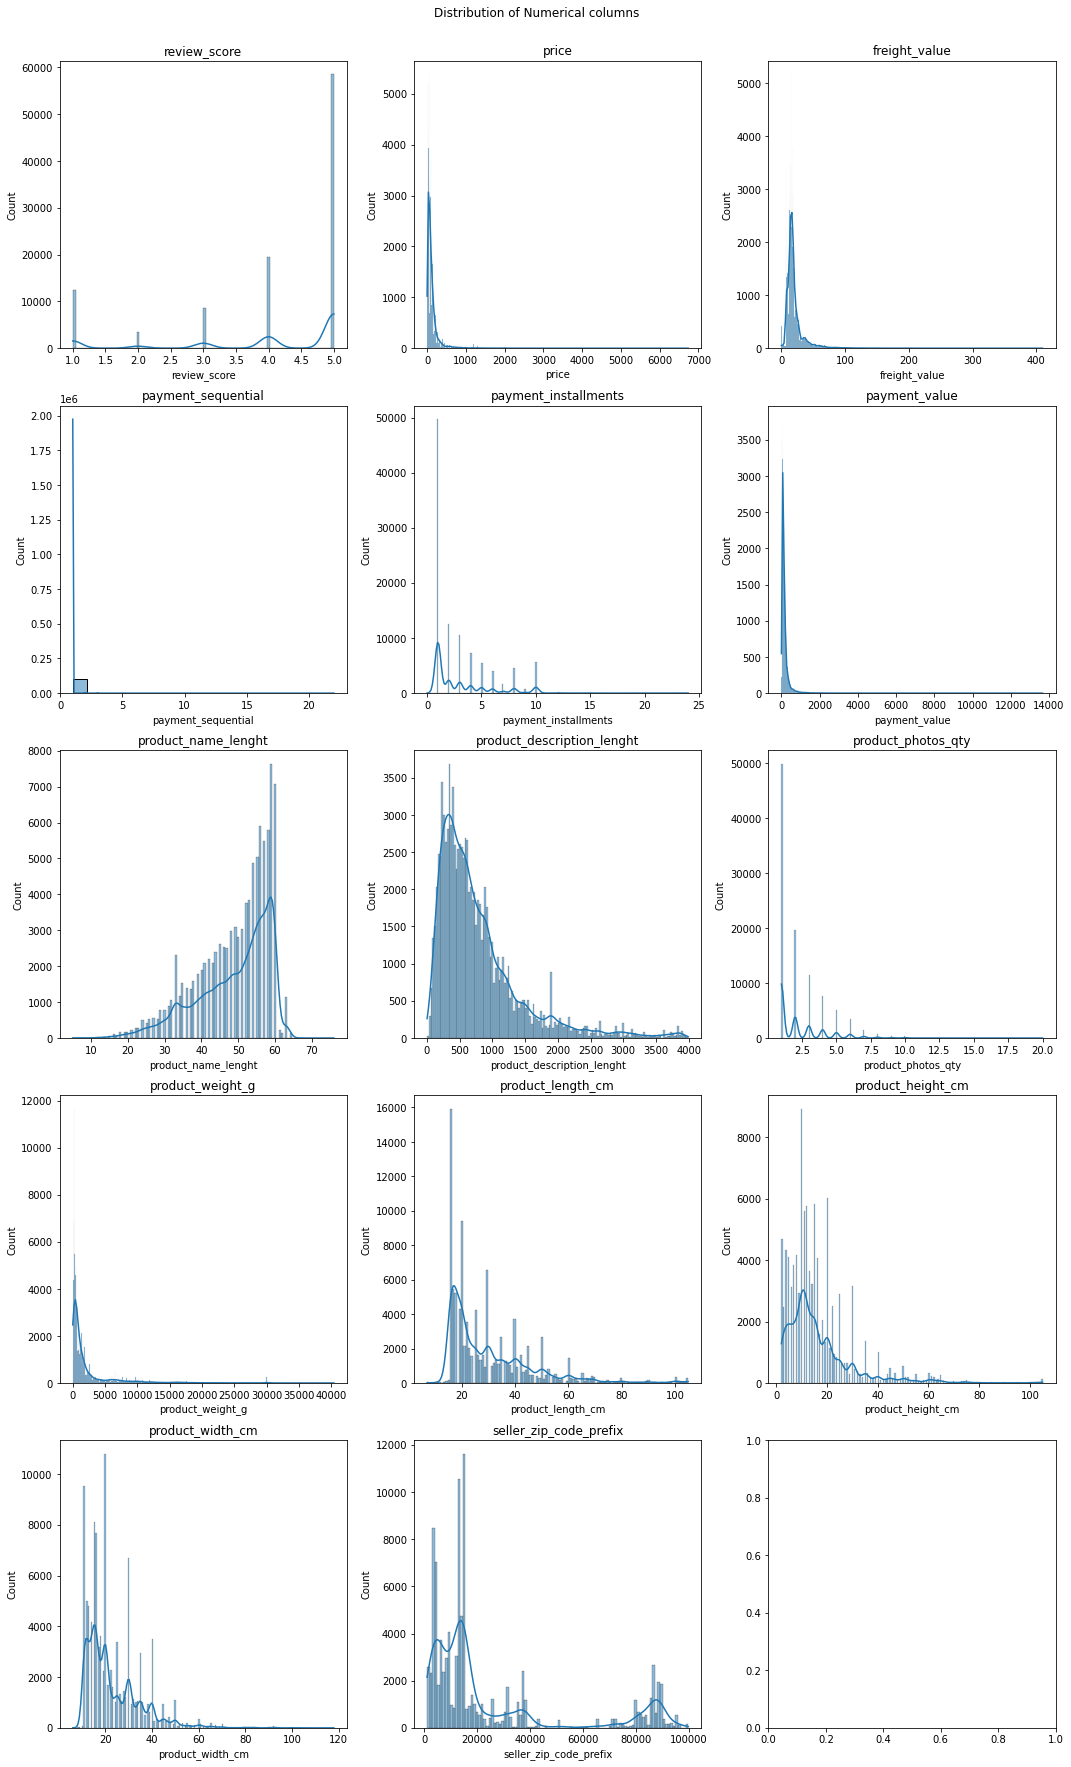

In [56]:
num_cols = len(numeric_cols)
num_rows = (num_cols + 2) // 3

fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
fig.suptitle('Distribution of Numerical columns')

for i, col_name in enumerate(numeric_cols):
    row_num = i // 3
    col_num = i % 3
    sns.histplot(modelling_df[col_name], ax=axs[row_num, col_num], kde=True)
    axs[row_num, col_num].set_title(col_name)

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

We can see that all of the numerical columns are skewed, however this may be due to outliers as we can see theres very little frequency towards the extreme end of some of the features. We will be treating every data point as important as they are data that is relevant to products currently being sold. Therefore, we need to impute any null values with the median value. It could be worth while making layers of models, for example, creating a model for lower priced items and a separate model for higher priced items. For simplicity's sake, I will create a general model for all prices and products.

In [57]:
# Numerical null values replaced with column mode value
imputation_num_dict = dict(zip(numeric_cols, modelling_df[numeric_cols].median().values.tolist()))

pprint(imputation_num_dict)

# Changing null values for numerical variables 
modelling_df[numeric_cols] = modelling_df[numeric_cols].fillna(value=imputation_num_dict)

{'freight_value': 16.32,
 'payment_installments': 2.0,
 'payment_sequential': 1.0,
 'payment_value': 105.74,
 'price': 78.8,
 'product_description_lenght': 603.0,
 'product_height_cm': 13.0,
 'product_length_cm': 25.0,
 'product_name_lenght': 52.0,
 'product_photos_qty': 2.0,
 'product_weight_g': 697.0,
 'product_width_cm': 20.0,
 'review_score': 5.0,
 'seller_zip_code_prefix': 13601.0}


## 4.0 Creating New Features

We have a lot of dates in our dataset that can't be used in our models. However, we can create numerical fields from these dates that could help explain the model in more detail. For example, we calculate the difference of dates in days and see if these have any relevance to our target.